In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
import matplotlib.patches as mpatches
import numpy as np

In [ ]:
class VoiceBiasAnalyzer:

    def __init__(self, data_directory='/content/drive/My Drive/articles/active_vs_passive_voice/combined_csvs'):
        self.entities = {
            'palestine': ['palestine', 'palestinian', 'palestinians'],
            'israel': ['israel', 'israeli', 'israelis'],
            'idf': ['idf', 'israeli defence force', 'israeli defense forces', 'israeli defense force', 'israeli defense forces'],
            'hamas': ['hamas'],
        }


        self.newssite_formatting = {
            'Apnews': 'AP News',
            'Bbc' : 'BBC',
            'Cnn' : 'CNN',
            'Foxnews' : 'Fox News',
            'Dailymail' : 'Dailymail',
            'Guardian' : 'Guardian',
            'Hindustantimes' : 'Hindustan Times',
            'India' : 'India',
            'Independent' : 'Independent',
            'Indianexpress' : 'Indian Express',
            'News18': 'News 18',
            'Nbc' : 'NBC',
            'Nypost' : 'NY Post',
            'Newsweek' : 'Newsweek',
            'Usatoday' : 'USA Today'
        }

        self.data = self.load_data(data_directory)
        self.results = self.analyze_voice_by_entity()
        self.percentages = self.calculate_percentages() # newssite -> entitities / calculates percentage of active/passive for each entity per newssite
        self.voice_distribution_df = self.create_voice_dist_df()

        self.death_words_df = self.create_death_words_df()

    def load_data(self, data_directory):
        data = {}

        for filename in os.listdir(data_directory):
            if filename.endswith('.csv'):
                news_site = os.path.splitext(filename)[0]
                filepath = os.path.join(data_directory, filename)
                data[news_site] = pd.read_csv(filepath)

        return data

    def identify_entity_in_span(self, text, span_text):
        israeli_not_idf_pattern = r'israeli(?!\s+(defense|defence)\s+(force|forces))'
        idf_pattern = r'\b(?:israeli\s+(?:defense|defence)\s+force(?:s)?|idf)\b'

        span_lower = span_text.lower()

        for entity, terms in self.entities.items():
            if entity == 'idf' and re.findall(idf_pattern, text, re.IGNORECASE):
                return entity
            else:
                for term in terms:
                    if term == 'israeli' and entity == 'israel':
                        # check to make sure its not matching on 'israeli defense force'
                        if re.findall(israeli_not_idf_pattern, text, re.IGNORECASE):
                            return entity
                    elif any(term in span_lower for term in terms):
                        return entity

        return None


    def analyze_voice_by_entity(self):

        results = {}

        for news_site, df in self.data.items():
            site_results = {
                'active': defaultdict(int), # count how many times each entity appears in the active voice
                'passive': defaultdict(int), # count how many times each entity appears in the passive voice
                'entity_counts': defaultdict(int) # count how many times each entity appears overall
            }

            active_df = df[df['voice_type'] == 'active']
            for _, row in active_df.iterrows():
                sentence = row['sentence']
                span = row['span']

                entity = self.identify_entity_in_span(sentence, span)
                if entity:
                    site_results['active'][entity] += 1
                    site_results['entity_counts'][entity] += 1

            passive_df = df[df['voice_type'] == 'passive']
            for _, row in passive_df.iterrows():
                sentence = row['sentence']
                span = row['span']

                entity = self.identify_entity_in_span(sentence, span)
                if entity:
                    site_results['passive'][entity] += 1
                    site_results['entity_counts'][entity] += 1

            results[news_site] = site_results

        return results

    def calculate_percentages(self):
        percentages = {}

        for news_site, site_results in self.results.items():
            site_percentages = {}

            for entity in self.entities:
                active_count = site_results['active'].get(entity, 0)
                passive_count = site_results['passive'].get(entity, 0)
                total = active_count + passive_count

                if total > 0:
                    active_pct = (active_count / total) * 100
                    passive_pct = (passive_count / total) * 100
                    site_percentages[entity] = {
                        'active_count': active_count,
                        'passive_count': passive_count,
                        'active_pct': active_pct,
                        'passive_pct': passive_pct,
                    }

            percentages[news_site] = site_percentages

        return percentages

    def create_voice_dist_df(self):
        voice_distribution = []

        for newssite, entities in self.percentages.items():
            for entity, percentages in entities.items():
                voice_distribution.append(
                    {
                        'News Site' : newssite.capitalize(),
                        'Entity' : entity.upper() if entity == 'idf' else entity.capitalize(),
                        'Active Voice Count': percentages['active_count'],
                        'Passive Voice Count': percentages['passive_count'],
                        'Active Voice %': percentages['active_pct'],
                        'Passive Voice %': percentages['passive_pct'],
                        'Active/Passive Ratio' : percentages['active_pct'] / percentages['passive_pct']
                    }
                )

        voice_distribution_df = pd.DataFrame(voice_distribution)

        voice_distribution_df['News Site'] = voice_distribution_df['News Site'].map(self.newssite_formatting)
        voice_distribution_df['Region'] = voice_distribution_df['News Site'].map(self.newssite_to_region)

        return voice_distribution_df


    def create_death_words_df(self):
        words = ['killed', 'murdered', 'died']
        people = ['palestinians', 'israelis']

        combinations = [(person, word) for word in words for person in people]

        death_words = []

        for newssite, df in self.data.items():

          for person, word in combinations:

            if word == 'killed':
              df_matches = df[(df['span'].str.contains(person, case=False)) & df['span'].str.contains(word, case=False)]
              number_active = len(df_matches[df_matches['voice_type'] == 'active'])
              number_passive = len(df_matches[df_matches['voice_type'] == 'passive'])
              death_words.append({
                'News Site' : newssite.capitalize(),
                'Entity' : person.capitalize(),
                'Word' : 'killed (active)',
                'Number of Occurrences' : number_active
            })
              death_words.append({
                'News Site' : newssite.capitalize(),
                'Entity' : person.capitalize(),
                'Word' : 'killed (passive)',
                'Number of Occurrences' : number_passive
            })

            else:

              number = len(df[df['span'].str.contains(person, case=False) & df['span'].str.contains(word, case=False)])
              death_words.append({
                  'News Site' : newssite.capitalize(),
                  'Entity' : person.capitalize(),
                  'Word' : word,
                  'Number of Occurrences' : number
              }
              )

        death_words_df = pd.DataFrame(death_words)



        death_words_df['News Site'] = death_words_df['News Site'].map(self.newssite_formatting)
        death_words_df['Region'] = death_words_df['News Site'].map(self.newssite_to_region)

        return death_words_df

    def newssite_to_region(self, newssite):
      if newssite in ['Dailymail', 'Independent', 'Guardian', 'BBC']:
        return 'UK'
      elif newssite in ['Hindustan Times', 'India', 'Indian Express', 'News 18']:
        return 'India'
      else:
        return 'US'

In [ ]:
analyzer = VoiceBiasAnalyzer()

In [ ]:
analyzer.data['apnews']

,sentence,span,voice_type
0,"\nBody of an Israeli hostage is found in Gaza,...",pier has been used,passive
1,"Sabrina Singh, a Pentagon spokeswoman, acknowl...",pier will be reinstalled,passive
2,Blinken also reiterated the need for more work...,work to be done,passive
3,The dead and injured were taken from Maghazi r...,they were viewed,passive
4,"A young girl, her face covered in blood and gr...",she was rushed,passive
...,...,...,...
130035,"Reimer Veldhuis, a lawyer representing the gov...",who operate the,active
130036,\nThe Netherlands is home to one of three F-35...,Netherlands is,active
130037,"Since then, Israeli ground offensives and bomb...",which does,active
130038,The war has caused massive devastation across ...,war has,active


In [ ]:
newssites = analyzer.data.keys()

In [ ]:
total_unique_sentences = {}

In [ ]:
for newsite in newssites:
  total_unique_sentences[newsite] = analyzer.data[newsite]['sentence'].nunique()

In [ ]:
total_unique_sentences

{'apnews': 73148,
 'bbc': 40755,
 'cnn': 38617,
 'foxnews': 30545,
 'dailymail': 58572,
 'guardian': 82957,
 'hindustantimes': 40426,
 'india': 4450,
 'independent': 79687,
 'indianexpress': 32764,
 'news18': 35153,
 'nbc': 18641,
 'nypost': 23661,
 'newsweek': 24918,
 'usatoday': 22533}

In [ ]:
newssite_formatting = {
            'apnews': 'AP News',
            'bbc' : 'BBC',
            'cnn' : 'CNN',
            'foxnews' : 'Fox News',
            'dailymail' : 'Dailymail',
            'guardian' : 'Guardian',
            'hindustantimes' : 'Hindustan Times',
            'india' : 'India',
            'independent' : 'Independent',
            'indianexpress' : 'Indian Express',
            'news18': 'News 18',
            'nbc' : 'NBC',
            'nypost' : 'NY Post',
            'newsweek' : 'Newsweek',
            'usatoday' : 'USA Today'
        }

In [ ]:
df_counts = pd.DataFrame(total_unique_sentences.items(), columns=['News Site', 'Number of Unique Sentences'])
df_counts['News Site'] = df_counts['News Site'].map(newssite_formatting)

In [ ]:
region_cols = {
    'US' : '#648FFF',
    'UK' : '#DC267F' ,
    'India' : '#FFB000'
}

def newssite_to_region(newssite):
      if newssite in ['Dailymail', 'Independent', 'Guardian', 'BBC']:
        return 'UK'
      elif newssite in ['Hindustan Times', 'India', 'Indian Express', 'News 18']:
        return 'India'
      else:
        return 'US'

df_counts['Region']  = df_counts['News Site'].apply(newssite_to_region)

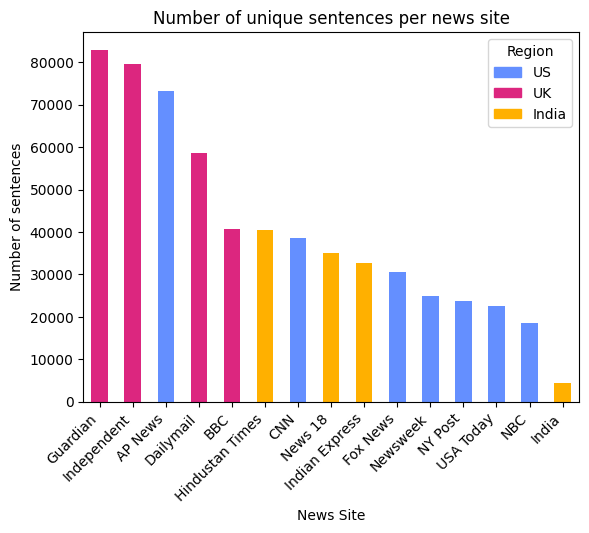

In [ ]:
df_plot = df_counts.sort_values(by='Number of Unique Sentences', ascending=False)

ax = df_plot.plot(kind='bar', x='News Site', y='Number of Unique Sentences', title='Number of unique sentences per news site', legend=False, color=df_plot['Region'].map(region_cols))
ax.set_ylabel("Number of sentences")
ax.set_xticklabels(df_plot['News Site'], rotation=45, ha="right")


us_patch = mpatches.Patch(color=region_cols['US'], label='US')
uk_patch = mpatches.Patch(color=region_cols['UK'], label='UK')
india_patch = mpatches.Patch(color=region_cols['India'], label='India')

ax.legend(handles=[us_patch, uk_patch, india_patch], title='Region')


ax.figure.savefig('uniquesents.png', bbox_inches="tight")

In [ ]:
total_per_voice = defaultdict(lambda: defaultdict(int))

for newssite, df in analyzer.data.items():
  total_per_voice[newssite]['passive'] = len(df[df['voice_type'] == 'passive'])
  total_per_voice[newssite]['active'] = len(df[df['voice_type'] == 'active'])

In [ ]:
total_per_voice

defaultdict(<function __main__.<lambda>()>,
            {'apnews': defaultdict(int, {'passive': 14220, 'active': 115820}),
             'bbc': defaultdict(int, {'passive': 9795, 'active': 59377}),
             'cnn': defaultdict(int, {'passive': 8278, 'active': 63208}),
             'foxnews': defaultdict(int, {'passive': 5878, 'active': 51180}),
             'dailymail': defaultdict(int,
                         {'passive': 20063, 'active': 110891}),
             'guardian': defaultdict(int,
                         {'passive': 52468, 'active': 335085}),
             'hindustantimes': defaultdict(int,
                         {'passive': 8264, 'active': 60509}),
             'india': defaultdict(int, {'passive': 942, 'active': 6534}),
             'independent': defaultdict(int,
                         {'passive': 16736, 'active': 122690}),
             'indianexpress': defaultdict(int,
                         {'passive': 6589, 'active': 49299}),
             'news18': defaultdict(i

In [ ]:
data = []
for site, counts in total_per_voice.items():
    data.append({
        'news_site': site,
        'passive_voice': counts['passive'],
        'active_voice': counts['active']
    })

df_total_per_voice = pd.DataFrame(data)
df_total_per_voice['news_site'] = df_total_per_voice['news_site'].map(newssite_formatting)

In [ ]:
df_total_per_voice.rename(columns={'news_site': 'News Site', 'passive_voice':'Passive Voice', 'active_voice' : 'Active Voice'}, inplace=True)

In [ ]:
df_total_per_voice.to_pickle('/content/drive/My Drive/articles/total_voice.pkl')

In [ ]:
df_total_per_voice['Active Voice Percentage']  = df_total_per_voice['Active Voice'] / (df_total_per_voice['Active Voice'] + df_total_per_voice['Passive Voice']) * 100
df_total_per_voice['Passive Voice Percentage']  = df_total_per_voice['Passive Voice'] / (df_total_per_voice['Active Voice'] + df_total_per_voice['Passive Voice']) * 100

In [ ]:
df_total_per_voice['Active Voice Percentage'].nsmallest(n=2)

,Active Voice Percentage
4,84.679353
1,85.839646


In [ ]:
df_total_per_voice.loc[4]

,4
News Site,Dailymail
Passive Voice,20063
Active Voice,110891
Active Voice Percentage,84.679353
Passive Voice Percentage,15.320647


In [ ]:
colours = ['purple', 'orange']

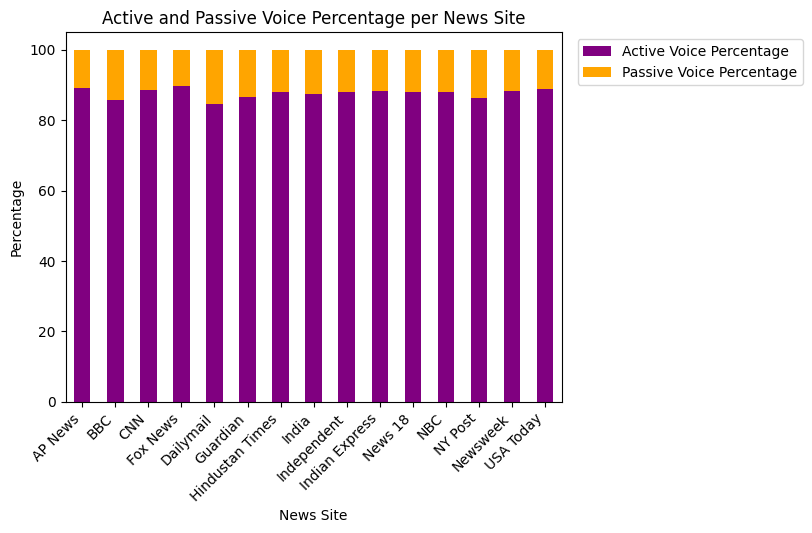

In [ ]:
ax = df_total_per_voice[['News Site', 'Active Voice Percentage', 'Passive Voice Percentage']].plot(kind='bar', x='News Site',color=colours, title="Active and Passive Voice Percentage per News Site", stacked=True, ylabel='Percentage')
ax.set_xticklabels(df_total_per_voice['News Site'], rotation=45, ha="right")
ax.legend(bbox_to_anchor=(1.5, 1), loc='upper right')

ax.figure.savefig('totalpervoice.png', bbox_inches="tight")

In [ ]:
df = analyzer.voice_distribution_df

In [ ]:
df.to_pickle('/content/drive/My Drive/articles/news_ap_voice.pkl')

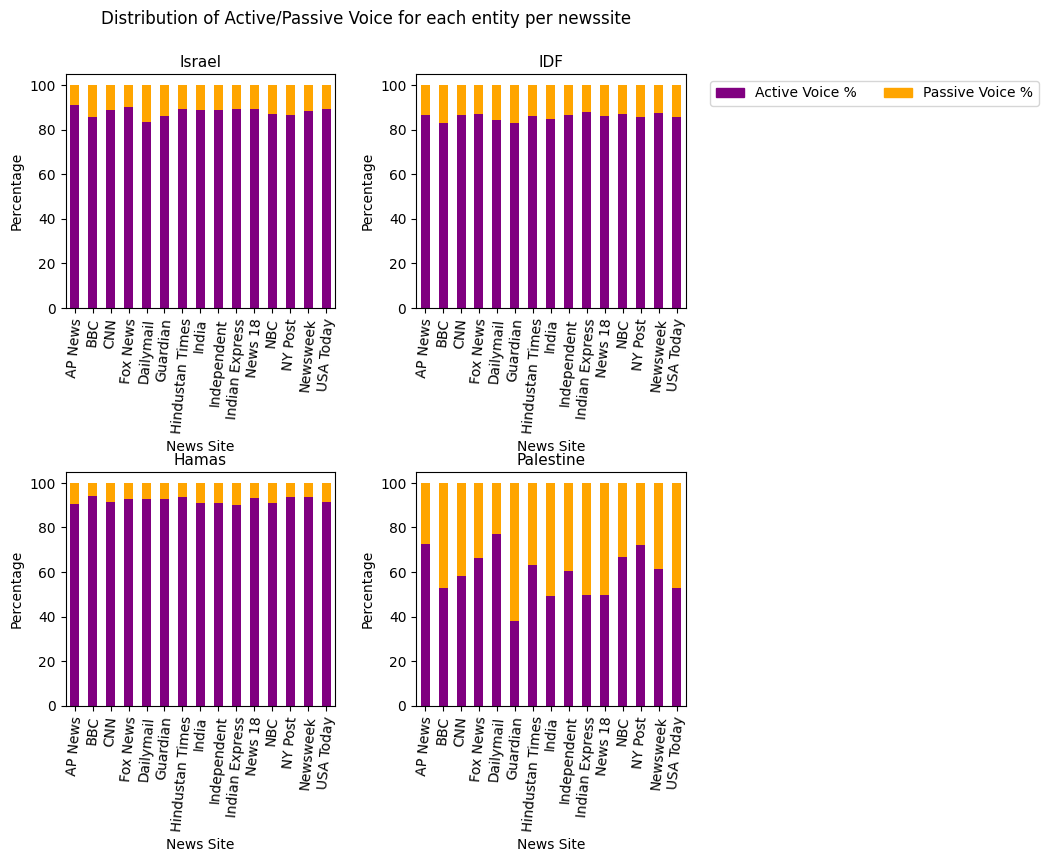

In [ ]:
## plot active vs passive voice per entity in one figure
padding = 5
fontsize = 11
labelsize = 10
labelrotation = 85


fig, axs = plt.subplots(2, 2, figsize=(8, 8))


ax1, ax2 = axs[0]
ax3, ax4 = axs[1]

df[df['Entity'] == 'Israel'][['News Site', 'Active Voice %', 'Passive Voice %']].plot(x='News Site', kind='bar', stacked=True, ax=ax1, legend=False, color=colours)
ax1.set_title("Israel", pad=padding,  fontsize= fontsize)
ax1.tick_params(axis='both', which='major', labelsize=labelsize)
ax1.tick_params(axis='x', which='major', labelrotation=labelrotation)
ax1.set_ylabel('Percentage')

df[df['Entity'] == 'IDF'][['News Site', 'Active Voice %', 'Passive Voice %']].plot(x='News Site', kind='bar', stacked=True, ax=ax2, legend=False, color=colours)
ax2.set_title("IDF", pad=padding,  fontsize= fontsize)
ax2.tick_params(axis='both', which='major', labelsize=labelsize)
ax2.tick_params(axis='x', which='major', labelrotation=labelrotation)
ax2.set_ylabel('Percentage')

df[df['Entity'] == 'Hamas'][['News Site', 'Active Voice %', 'Passive Voice %']].plot(x='News Site', kind='bar', stacked=True, ax=ax3, legend=False, color=colours)
ax3.set_title("Hamas", pad=padding,  fontsize= fontsize)
ax3.tick_params(axis='both', which='major', labelsize=labelsize)
ax3.tick_params(axis='x', which='major', labelrotation=labelrotation)
ax3.set_ylabel('Percentage')

df[df['Entity'] == 'Palestine'][['News Site', 'Active Voice %', 'Passive Voice %']].plot(x='News Site', kind='bar', stacked=True, ax=ax4, legend=False, color=colours)
ax4.set_title("Palestine", pad=padding,  fontsize= fontsize)
ax4.tick_params(axis='both', which='major', labelsize=labelsize)
ax4.tick_params(axis='x', which='major', labelrotation=labelrotation)
ax4.set_ylabel('Percentage')

active_patch = mpatches.Patch(color=colours[0], label='Active Voice %')
passive_patch = mpatches.Patch(color=colours[1], label='Passive Voice %')

fig.legend(handles=[active_patch, passive_patch],
           loc='upper right',
           bbox_to_anchor=(1.35, 0.9),
           ncol=2)

fig.subplots_adjust(
    top=0.9,
    hspace=0.7,
    wspace=0.3
)

fig.suptitle("Distribution of Active/Passive Voice for each entity per newssite")

plt.show()

In [ ]:
df_sorted = df.sort_values(by='Region')

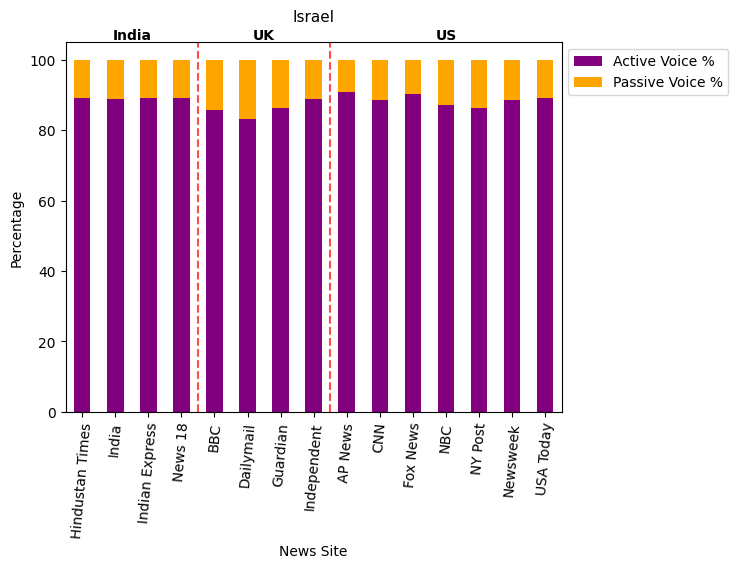

In [ ]:
israel_df = df[df['Entity'] == 'Israel']

israel_df = israel_df.sort_values(by='Region')

ax1 = israel_df[['News Site', 'Active Voice %', 'Passive Voice %']].plot(x='News Site', kind='bar', stacked=True, legend=True, color=colours)
ax1.set_title("Israel", pad=padding+10,  fontsize= fontsize)
ax1.tick_params(axis='both', which='major', labelsize=labelsize)
ax1.tick_params(axis='x', which='major', labelrotation=labelrotation)
ax1.set_ylabel('Percentage')
ax1.legend(bbox_to_anchor=(1.35, 1), loc='upper right')

region_boundaries = [4, 8]
region_names = ["India", "UK", "US"]

y_max = ax1.get_ylim()[1]

for i, pos in enumerate(region_boundaries):
    if pos < len(israel_df):
        ax1.axvline(x=pos - 0.5, color='red', linestyle='--', alpha=0.7)

region_centers = []
region_centers.append(region_boundaries[0] / 2 - 0.5)

middle_center = (region_boundaries[0] + region_boundaries[1]) / 2 - 0.5
region_centers.append(middle_center)

last_center = (region_boundaries[-1] + len(israel_df)) / 2 - 0.5
region_centers.append(last_center)

for i, center in enumerate(region_centers):
    ax1.text(center, y_max, region_names[i],
            ha='center', va='bottom', fontsize=10, fontweight='bold')

ax1.figure.savefig("israelapvoice.png", bbox_inches = "tight")

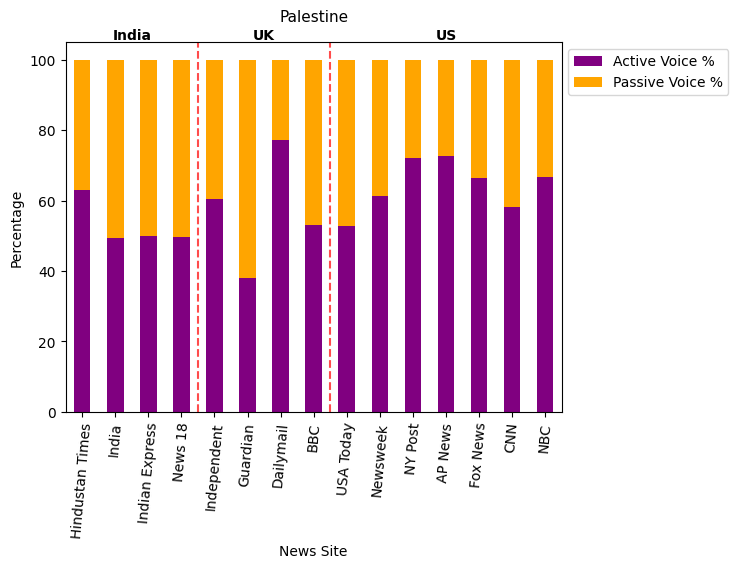

In [ ]:
palestine_df = df_sorted[df_sorted['Entity'] == 'Palestine']

ax1 = palestine_df[['News Site', 'Active Voice %', 'Passive Voice %']].plot(x='News Site', kind='bar', stacked=True, legend=True, color=colours)
ax1.set_title("Palestine", pad=padding+10,  fontsize= fontsize)
ax1.tick_params(axis='both', which='major', labelsize=labelsize)
ax1.tick_params(axis='x', which='major', labelrotation=labelrotation)
ax1.legend(bbox_to_anchor=(1.35, 1), loc='upper right')



region_boundaries = [4, 8]
region_names = ["India", "UK", "US"]

y_max = ax1.get_ylim()[1]

for i, pos in enumerate(region_boundaries):
    if pos < len(palestine_df):
        ax1.axvline(x=pos - 0.5, color='red', linestyle='--', alpha=0.7)

region_centers = []
region_centers.append(region_boundaries[0] / 2 - 0.5)

middle_center = (region_boundaries[0] + region_boundaries[1]) / 2 - 0.5
region_centers.append(middle_center)

last_center = (region_boundaries[-1] + len(palestine_df)) / 2 - 0.5
region_centers.append(last_center)

for i, center in enumerate(region_centers):
    ax1.text(center, y_max, region_names[i],
            ha='center', va='bottom', fontsize=10, fontweight='bold')


ax1.set_ylabel('Percentage')
ax1.figure.savefig("palestineapvoice.png", bbox_inches = "tight")

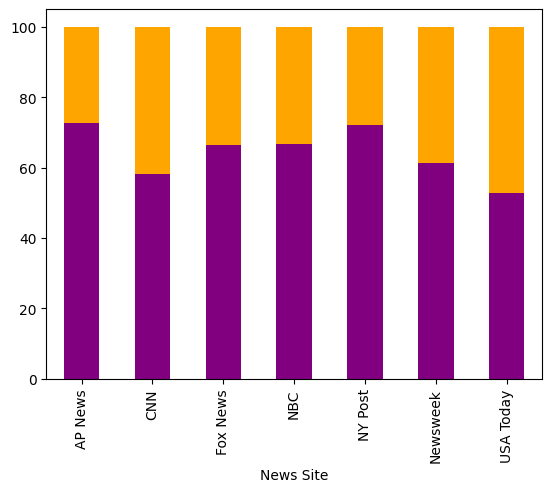

In [ ]:
ax1 = df[(df['Entity'] == 'Palestine') & (df['Region'] == 'US')][['News Site', 'Active Voice %', 'Passive Voice %']].plot(x='News Site', kind='bar', stacked=True, legend=False, color=colours)


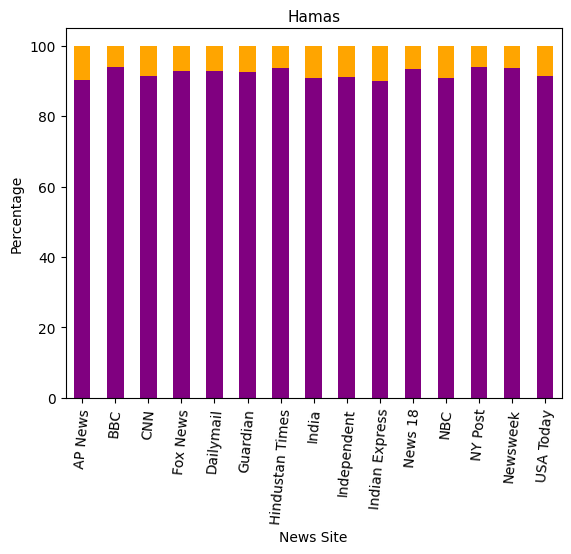

In [ ]:
ax1 = df[df['Entity'] == 'Hamas'][['News Site', 'Active Voice %', 'Passive Voice %']].plot(x='News Site', kind='bar', stacked=True, legend=False, color=colours)
ax1.set_title("Hamas", pad=padding,  fontsize= fontsize)
ax1.tick_params(axis='both', which='major', labelsize=labelsize)
ax1.tick_params(axis='x', which='major', labelrotation=labelrotation)
ax1.set_ylabel('Percentage')
ax1.figure.savefig("hamasapvoice.png", bbox_inches = "tight")

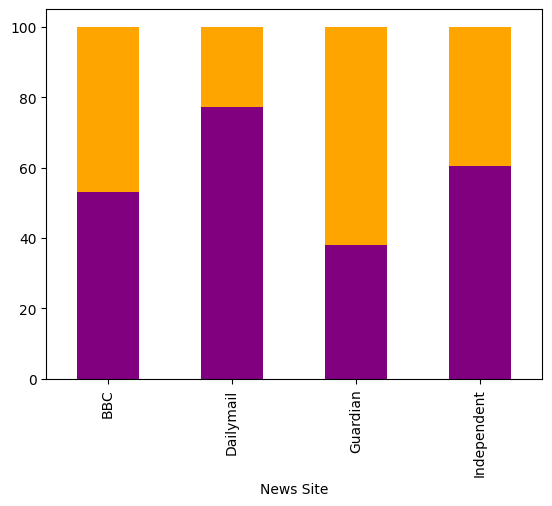

In [ ]:
ax1 = df[(df['Entity'] == 'Palestine') & (df['Region'] == 'UK')][['News Site', 'Active Voice %', 'Passive Voice %']].plot(x='News Site', kind='bar', stacked=True, legend=False, color=colours)


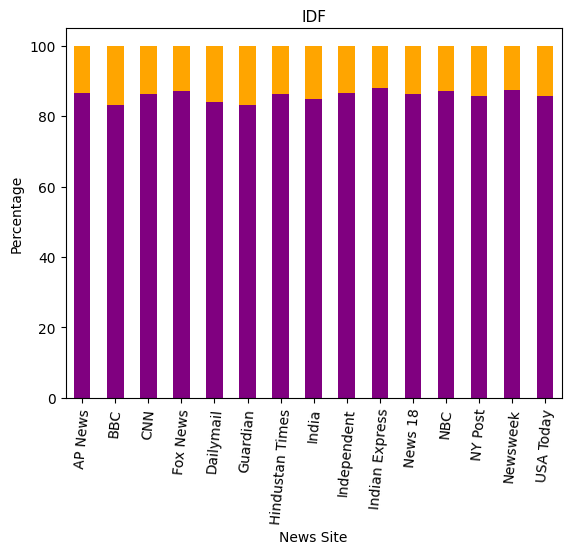

In [ ]:
ax1 = df[df['Entity'] == 'IDF'][['News Site', 'Active Voice %', 'Passive Voice %']].plot(x='News Site', kind='bar', stacked=True, legend=False, color=colours)
ax1.set_title("IDF", pad=padding,  fontsize= fontsize)
ax1.tick_params(axis='both', which='major', labelsize=labelsize)
ax1.tick_params(axis='x', which='major', labelrotation=labelrotation)
ax1.set_ylabel('Percentage')

ax1.figure.savefig("idfapvoice.png", bbox_inches = "tight")

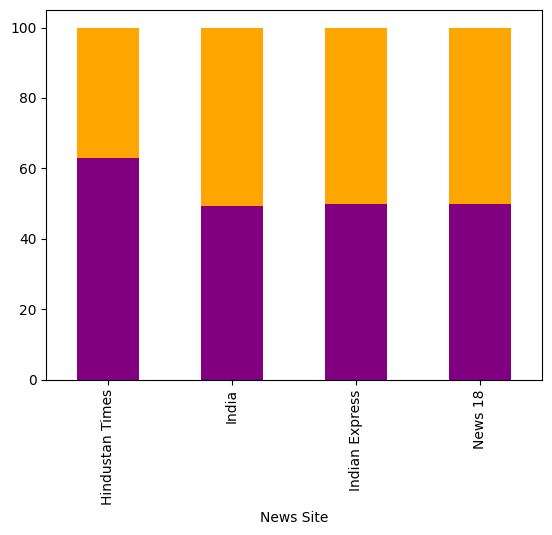

In [ ]:
ax1 = df[(df['Entity'] == 'Palestine') & (df['Region'] == 'India')][['News Site', 'Active Voice %', 'Passive Voice %']].plot(x='News Site', kind='bar', stacked=True, legend=False, color=colours)

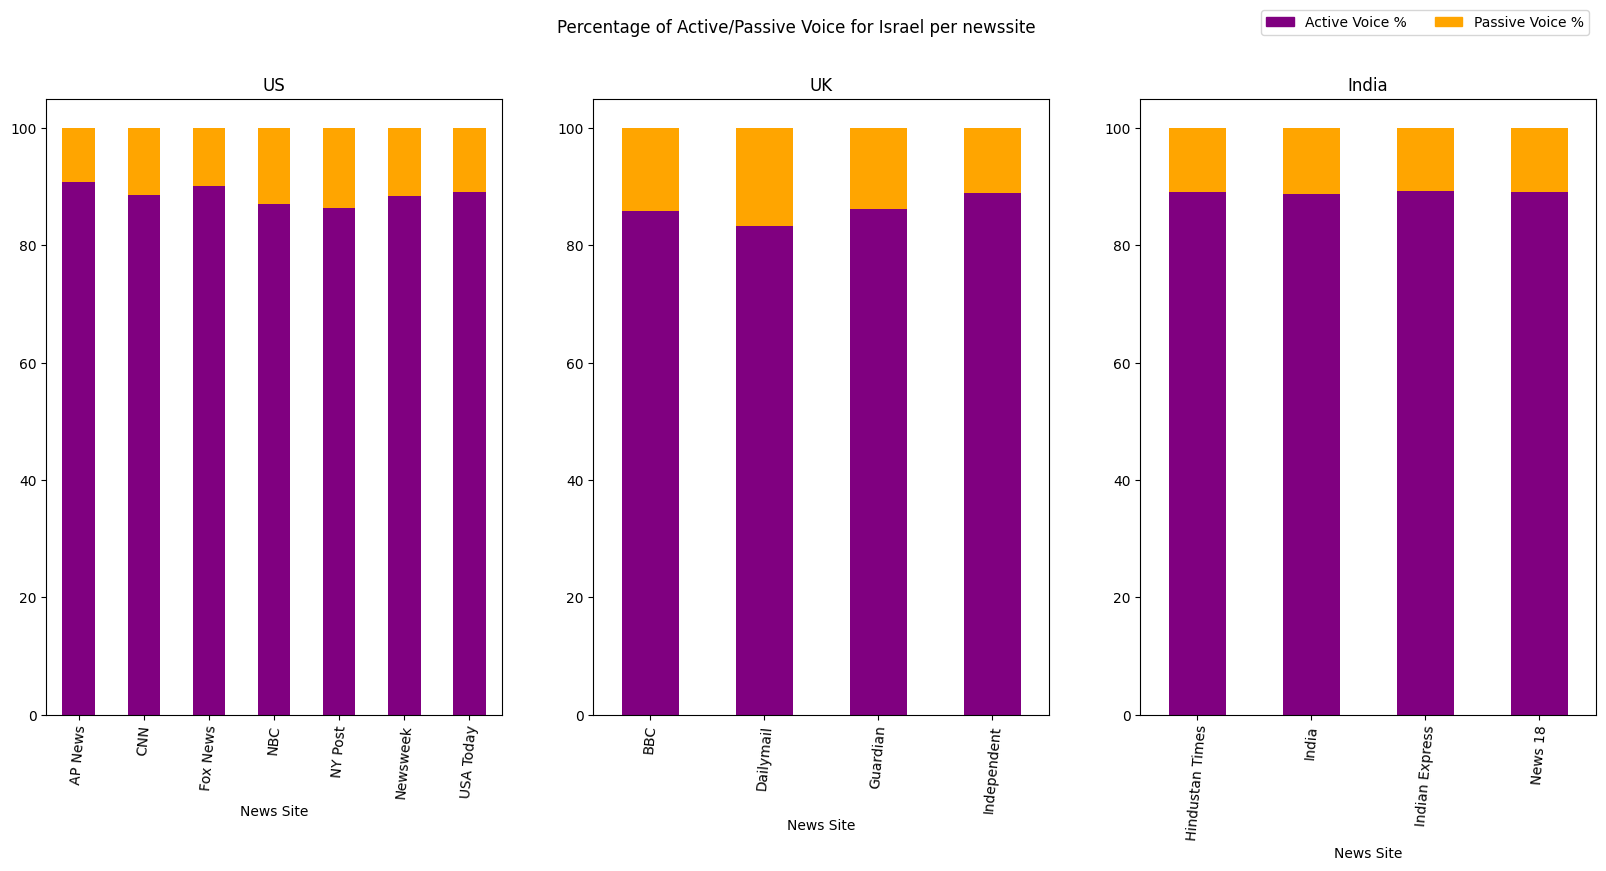

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20, 8))
ax1, ax2, ax3 = axs

df[(df['Entity'] == 'Israel') & (df['Region'] == 'US')][['News Site', 'Active Voice %', 'Passive Voice %']].plot(x='News Site', kind='bar', ax=ax1, stacked=True, legend=False, color=colours)
df[(df['Entity'] == 'Israel') & (df['Region'] == 'UK')][['News Site', 'Active Voice %', 'Passive Voice %']].plot(x='News Site', kind='bar', ax=ax2, stacked=True, legend=False, color=colours)
df[(df['Entity'] == 'Israel') & (df['Region'] == 'India')][['News Site', 'Active Voice %', 'Passive Voice %']].plot(x='News Site', kind='bar', ax=ax3, stacked=True, legend=False, color=colours)

fig.suptitle("Percentage of Active/Passive Voice for Israel per newssite")
ax1.set_title("US")
ax1.tick_params(axis='x', which='major', labelrotation=labelrotation)
ax3.tick_params(axis='both', which='major', labelsize=labelsize)


ax2.set_title("UK")
ax2.tick_params(axis='x', which='major', labelrotation=labelrotation)
ax2.tick_params(axis='both', which='major', labelsize=labelsize)

ax3.set_title("India")
ax3.tick_params(axis='x', which='major', labelrotation=labelrotation)
ax3.tick_params(axis='both', which='major', labelsize=labelsize)

active_patch = mpatches.Patch(color=colours[0], label='Active Voice %')
passive_patch = mpatches.Patch(color=colours[1], label='Passive Voice %')

fig.legend(handles=[active_patch, passive_patch],
           loc='upper right',
           bbox_to_anchor=(0.9, 1),
           ncol=2)

fig.savefig("israelapregion.png", bbox_inches="tight")

In [ ]:
df[(df['Entity'] == 'Palestine')]['Active Voice %'].argmax()

np.int64(4)

In [ ]:
df_death = analyzer.death_words_df

In [ ]:
per_entity = df_death.groupby(['Entity', 'Word'])['Number of Occurrences'].sum().reset_index()

In [ ]:
per_entity.to_pickle('per_entity_counts.pkl')

In [ ]:
entity_totals = per_entity.groupby('Entity')['Number of Occurrences'].sum().reset_index()
entity_totals.rename(columns={'Number of Occurrences': 'Total'}, inplace=True)

In [ ]:
df_with_totals = pd.merge(per_entity, entity_totals, on='Entity')
df_with_totals['Percentage'] = df_with_totals['Number of Occurrences'] / df_with_totals['Total'] * 100

In [ ]:
pivot_df = df_with_totals.pivot(index='Entity', columns='Word', values='Percentage')


In [ ]:
pivot_df

Word,died,killed (active),killed (passive),murdered
Entity,,,,
Israelis,11.806798,1.431127,82.468694,4.293381
Palestinians,3.996120,0.096993,95.868089,0.038797


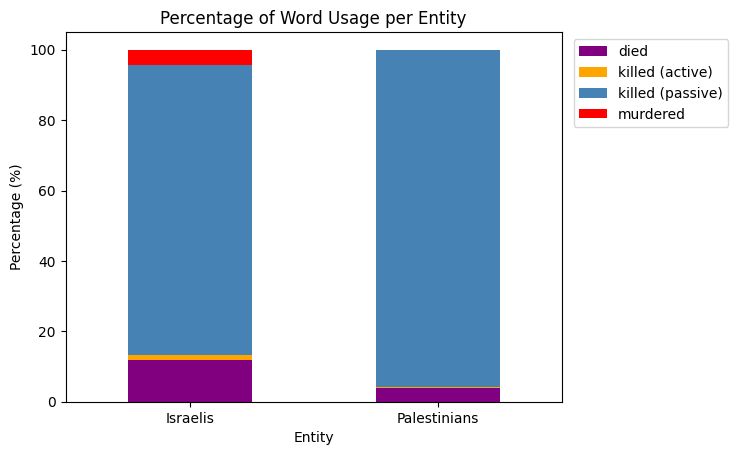

In [ ]:
colours_2 = ['purple', 'orange', 'steelblue', 'red']

ax = pivot_df.plot(kind='bar', stacked=True, color=colours_2)
ax.legend(bbox_to_anchor=(1.35, 1), loc='upper right')
ax.set_ylabel("Percentage (%)")
ax.set_title("Percentage of Word Usage per Entity")
ax.tick_params(axis='x', which='major', labelrotation=360)

ax.figure.savefig("wordusageoverall.png", bbox_inches="tight")

In [ ]:
df_death

,News Site,Entity,Word,Number of Occurrences,Region
0,AP News,Palestinians,killed (active),1,US
1,AP News,Palestinians,killed (passive),463,US
2,AP News,Israelis,killed (active),1,US
3,AP News,Israelis,killed (passive),23,US
4,AP News,Palestinians,murdered,0,US
...,...,...,...,...,...
115,USA Today,Israelis,killed (passive),21,US
116,USA Today,Palestinians,murdered,0,US
117,USA Today,Israelis,murdered,0,US
118,USA Today,Palestinians,died,18,US


In [ ]:
per_site = df_death.groupby(['News Site', 'Entity'])['Number of Occurrences'].sum().reset_index()

In [ ]:
per_site_totals = per_site.groupby(['News Site', 'Entity'])['Number of Occurrences'].sum().reset_index()
per_site_totals.rename(columns={'Number of Occurrences': 'Total'}, inplace=True)

In [ ]:
per_site_totals

,News Site,Entity,Total
0,AP News,Israelis,25
1,AP News,Palestinians,484
2,BBC,Israelis,37
3,BBC,Palestinians,183
4,CNN,Israelis,10
5,CNN,Palestinians,123
6,Dailymail,Israelis,65
7,Dailymail,Palestinians,307
8,Fox News,Israelis,37
9,Fox News,Palestinians,122


In [ ]:
df_per_site = df_death.copy()

df_per_site_totals = pd.merge(df_per_site, per_site_totals, on=['News Site', 'Entity'])
df_per_site_totals['Percentage'] = df_per_site_totals['Number of Occurrences'] / df_per_site_totals['Total'] * 100

df_per_site_totals.to_pickle('/content/drive/My Drive/articles/per_site_counts.pkl')

In [ ]:
df_per_site_israelis = df_per_site_totals[df_per_site_totals['Entity'] == 'Israelis'].sort_values(['Region', 'News Site'])
df_per_site_palestinians = df_per_site_totals[df_per_site_totals['Entity'] == 'Palestinians'].sort_values(['Region', 'News Site'])

In [ ]:
original_order_israelis = df_per_site_israelis['News Site'].unique()
original_order_palestinians = df_per_site_palestinians['News Site'].unique()

In [ ]:
pivot_newssite_israelis = df_per_site_israelis.pivot(index='News Site', columns='Word', values='Percentage').reindex(index=original_order_israelis)
pivot_newssite_palestinians = df_per_site_palestinians.pivot(index='News Site', columns='Word', values='Percentage').reindex(index=original_order_palestinians)

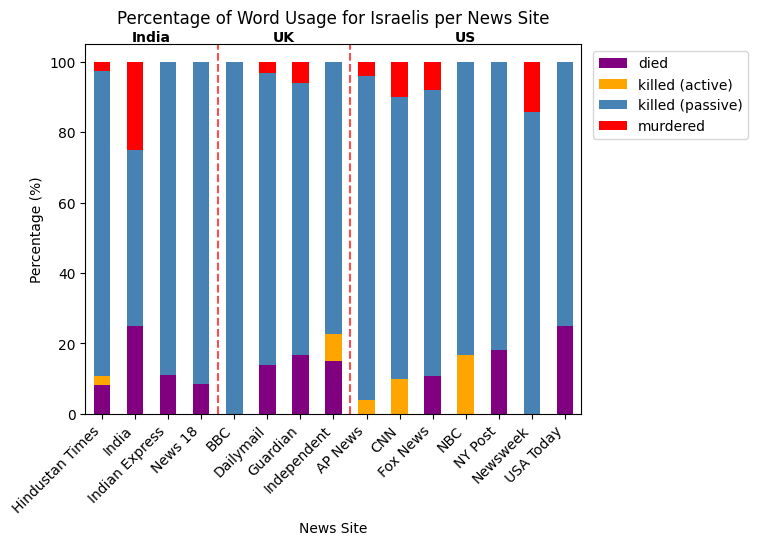

In [ ]:
ax = pivot_newssite_israelis.plot(kind='bar', stacked=True, color=colours_2)
ax.legend(bbox_to_anchor=(1.35, 1), loc='upper right')
ax.set_ylabel("Percentage (%)")
ax.set_title("Percentage of Word Usage for Israelis per News Site", pad=padding+10)
ax.set_xticklabels(df_per_site_israelis['News Site'].unique(), rotation=45, ha="right")

region_boundaries = [4, 8]
region_names = ["India", "UK", "US"]

y_max = ax.get_ylim()[1]

for i, pos in enumerate(region_boundaries):
    if pos < len(palestine_df):
        ax.axvline(x=pos - 0.5, color='red', linestyle='--', alpha=0.7)

region_centers = []
region_centers.append(region_boundaries[0] / 2 - 0.5)

middle_center = (region_boundaries[0] + region_boundaries[1]) / 2 - 0.5
region_centers.append(middle_center)

last_center = (region_boundaries[-1] + len(palestine_df)) / 2 - 0.5
region_centers.append(last_center)

for i, center in enumerate(region_centers):
    ax.text(center, y_max, region_names[i],
            ha='center', va='bottom', fontsize=10, fontweight='bold')


ax.figure.savefig("wordusageisrael.png", bbox_inches="tight")
plt.show()

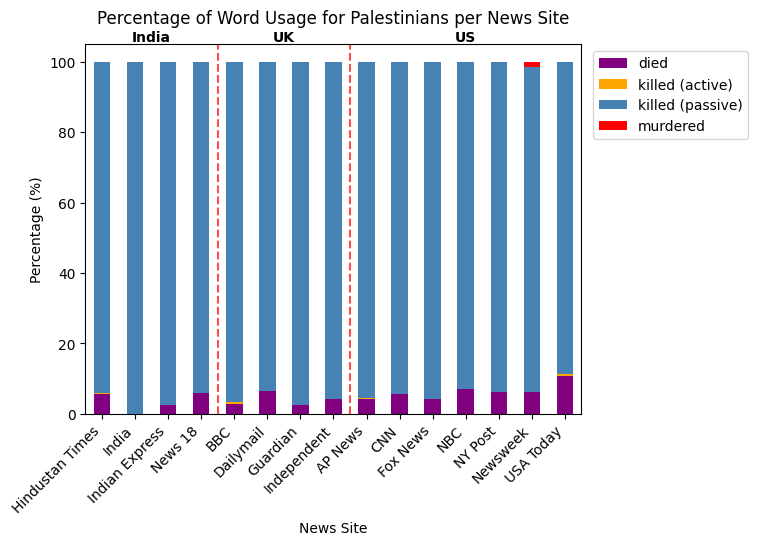

In [ ]:
ax = pivot_newssite_palestinians.plot(kind='bar', stacked=True, color=colours_2)
ax.legend(bbox_to_anchor=(1.35, 1), loc='upper right')
ax.set_ylabel("Percentage (%)")
ax.set_title("Percentage of Word Usage for Palestinians per News Site", pad=padding+10)
ax.set_xticklabels(df_per_site_palestinians['News Site'].unique(), rotation=45, ha="right")

region_boundaries = [4, 8]
region_names = ["India", "UK", "US"]

y_max = ax.get_ylim()[1]

for i, pos in enumerate(region_boundaries):
    if pos < len(palestine_df):
        ax.axvline(x=pos - 0.5, color='red', linestyle='--', alpha=0.7)

region_centers = []
region_centers.append(region_boundaries[0] / 2 - 0.5)

middle_center = (region_boundaries[0] + region_boundaries[1]) / 2 - 0.5
region_centers.append(middle_center)

last_center = (region_boundaries[-1] + len(palestine_df)) / 2 - 0.5
region_centers.append(last_center)

for i, center in enumerate(region_centers):
    ax.text(center, y_max, region_names[i],
            ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.figure.savefig("wordusagepalestine.png", bbox_inches="tight")
plt.show()

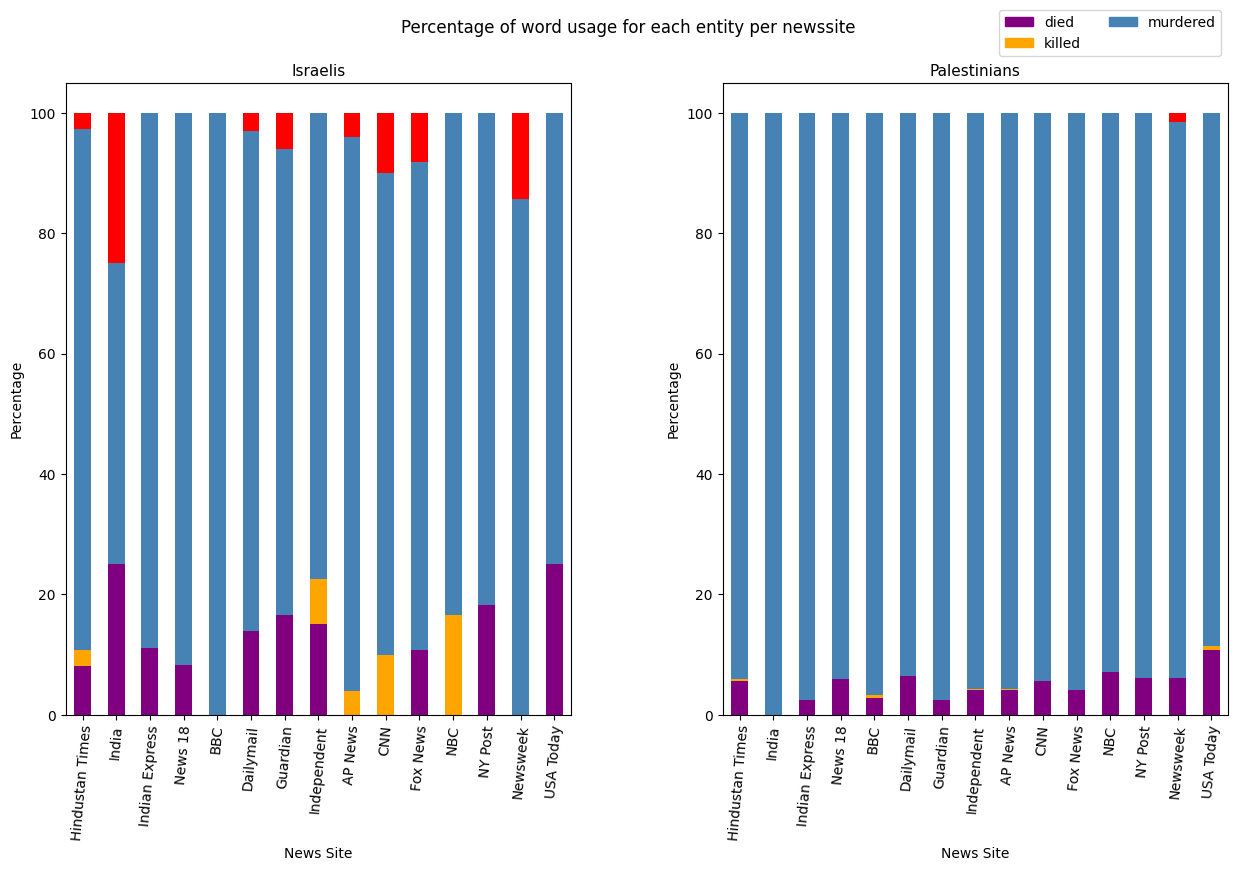

In [ ]:
## plot word usage per site per entity in one figure
padding = 5
fontsize = 11
labelsize = 10
labelrotation = 85

fig2, axs2 = plt.subplots(1, 2, figsize=(15, 8))

ax1, ax2 = axs2

pivot_newssite_israelis.plot(kind='bar', stacked=True, color=colours_2, ax=ax1, legend=False)
ax1.set_title("Israelis", pad=padding,  fontsize= fontsize)
ax1.tick_params(axis='both', which='major', labelsize=labelsize)
ax1.tick_params(axis='x', which='major', labelrotation=labelrotation)
ax1.set_ylabel('Percentage')

pivot_newssite_palestinians.plot(kind='bar', stacked=True, color=colours_2, ax=ax2, legend=False)
ax2.set_title("Palestinians", pad=padding,  fontsize= fontsize)
ax2.tick_params(axis='both', which='major', labelsize=labelsize)
ax2.tick_params(axis='x', which='major', labelrotation=labelrotation)
ax2.set_ylabel('Percentage')

died_patch = mpatches.Patch(color=colours_2[0], label='died')
killed_patch = mpatches.Patch(color=colours_2[1], label='killed')
murdered_patch = mpatches.Patch(color=colours_2[2], label='murdered')

fig2.legend(handles=[died_patch, killed_patch, murdered_patch],
           loc='upper right',
           bbox_to_anchor=(0.9, 1),
           ncol=2)

fig2.subplots_adjust(
    top=0.9,
    hspace=0.7,
    wspace=0.3
)

fig2.suptitle("Percentage of word usage for each entity per newssite")

plt.show()

In [ ]:
## look at just murdered vs died

df_per_site_without_killed  = df_per_site[df_per_site['Word'] != 'killed']

In [ ]:
per_site_without_killed = df_per_site_without_killed.groupby(['News Site', 'Entity'])['Number of Occurrences'].sum().reset_index()
per_site_without_killed.rename(columns={'Number of Occurrences':'Total'}, inplace=True)

In [ ]:
df_without_killed_totals = pd.merge(df_per_site_without_killed, per_site_without_killed, on=['News Site', 'Entity'])
df_without_killed_totals['Percentage'] = df_without_killed_totals['Number of Occurrences'] / df_without_killed_totals['Total'] * 100

In [ ]:
df_per_site_without_killed_israelis = df_without_killed_totals[df_without_killed_totals['Entity'] == 'Israelis']
df_per_site_without_killed_palestinians = df_without_killed_totals[df_without_killed_totals['Entity'] == 'Palestinians']

In [ ]:
pivot_newssite_israelis_without_killed = df_per_site_without_killed_israelis.pivot(index='News Site', columns='Word', values='Percentage')
pivot_newssite_palestinians_without_killed = df_per_site_without_killed_palestinians.pivot(index='News Site', columns='Word', values='Percentage')

In [ ]:
colours_3 = ['purple', 'steelblue']

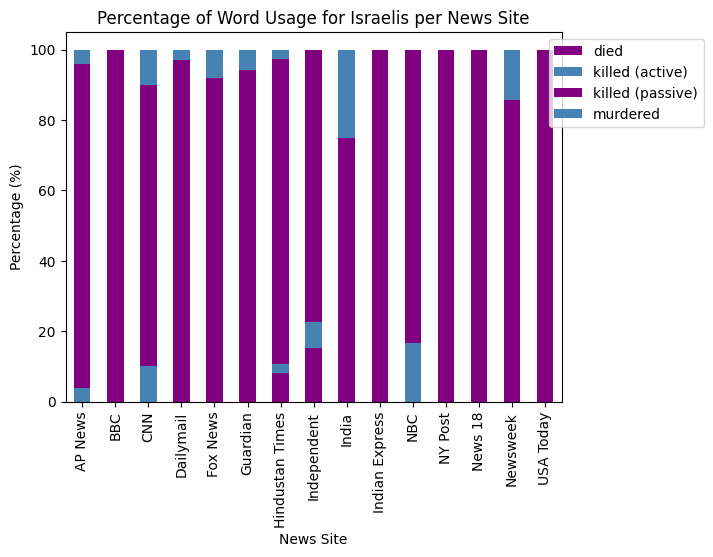

In [ ]:
ax = pivot_newssite_israelis_without_killed.plot(kind='bar', stacked=True, color=colours_3)
ax.legend(bbox_to_anchor=(1.3, 1), loc='upper right')
ax.set_ylabel("Percentage (%)")
ax.set_title("Percentage of Word Usage for Israelis per News Site")
plt.show()

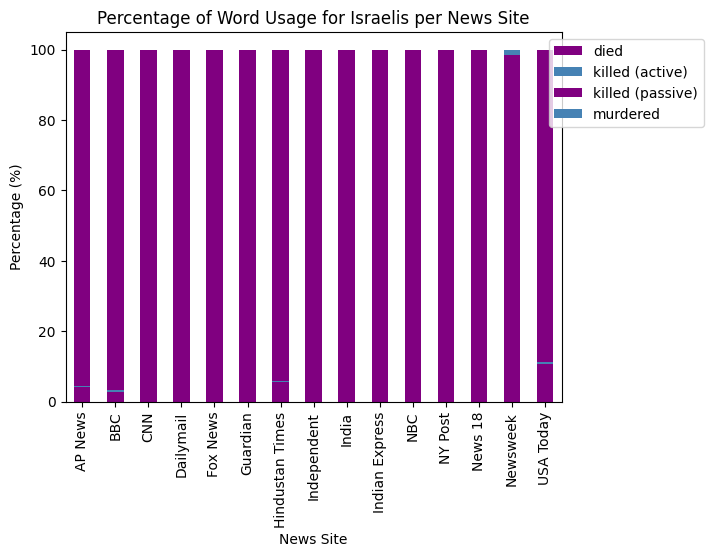

In [ ]:
ax = pivot_newssite_palestinians_without_killed.plot(kind='bar', stacked=True, color=colours_3)
ax.legend(bbox_to_anchor=(1.3, 1), loc='upper right')
ax.set_ylabel("Percentage (%)")
ax.set_title("Percentage of Word Usage for Israelis per News Site")
plt.show()

In [ ]:
## plot per region


In [ ]:
#us
df_per_site_without_killed_israelis_us = df_without_killed_totals[(df_without_killed_totals['Entity'] == 'Israelis') & (df_without_killed_totals['Region'] == 'US')]
df_per_site_without_killed_palestinians_us = df_without_killed_totals[(df_without_killed_totals['Entity'] == 'Palestinians') & (df_without_killed_totals['Region'] == 'US')]
pivot_us_israelis_without_killed = df_per_site_without_killed_israelis_us.pivot(index='News Site', columns='Word', values='Percentage')
pivot_us_palestinians_without_killed = df_per_site_without_killed_palestinians_us.pivot(index='News Site', columns='Word', values='Percentage')


#uk
df_per_site_without_killed_israelis_uk = df_without_killed_totals[(df_without_killed_totals['Entity'] == 'Israelis') & (df_without_killed_totals['Region'] == 'UK')]
df_per_site_without_killed_palestinians_uk = df_without_killed_totals[(df_without_killed_totals['Entity'] == 'Palestinians') & (df_without_killed_totals['Region'] == 'UK')]
pivot_uk_israelis_without_killed = df_per_site_without_killed_israelis_uk.pivot(index='News Site', columns='Word', values='Percentage')
pivot_uk_palestinians_without_killed = df_per_site_without_killed_palestinians_uk.pivot(index='News Site', columns='Word', values='Percentage')


#india
df_per_site_without_killed_israelis_india = df_without_killed_totals[(df_without_killed_totals['Entity'] == 'Israelis') & (df_without_killed_totals['Region'] == 'India')]
df_per_site_without_killed_palestinians_india = df_without_killed_totals[(df_without_killed_totals['Entity'] == 'Palestinians') & (df_without_killed_totals['Region'] == 'India')]
pivot_india_israelis_without_killed = df_per_site_without_killed_israelis_india.pivot(index='News Site', columns='Word', values='Percentage')
pivot_india_palestinians_without_killed = df_per_site_without_killed_palestinians_india.pivot(index='News Site', columns='Word', values='Percentage')

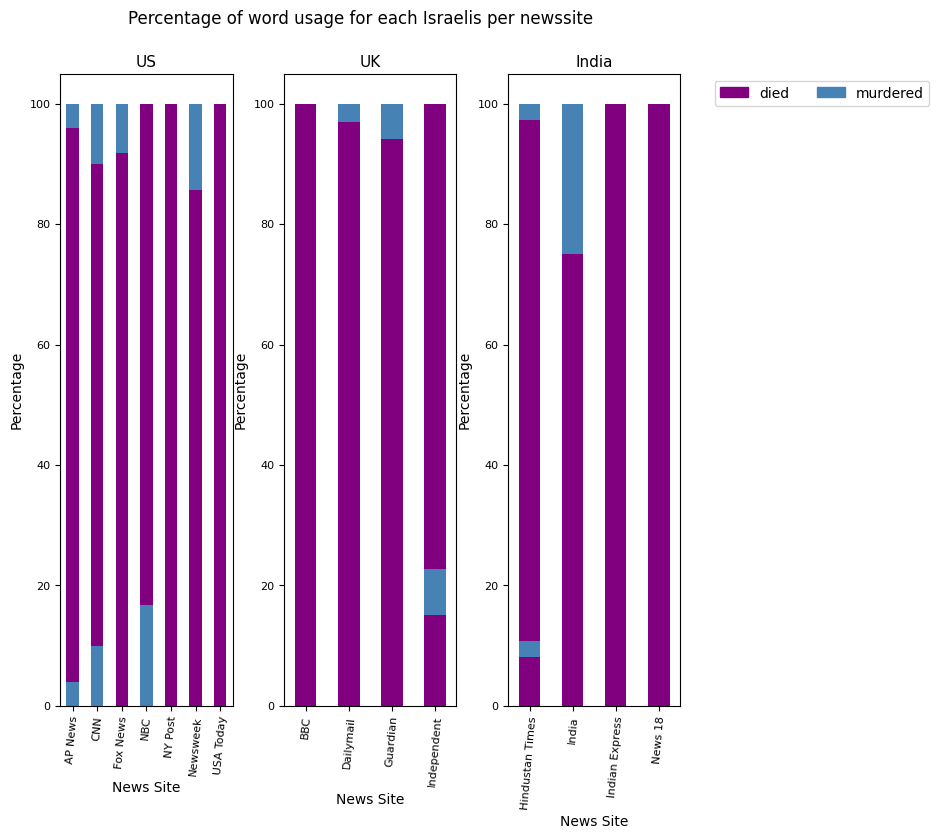

In [ ]:
## plot word usage per site per entity in one figure
padding = 5
fontsize = 11
labelsize = 8
labelrotation = 85

fig3, axs3 = plt.subplots(1, 3, figsize=(8, 8))

ax1, ax2, ax3 = axs3

pivot_us_israelis_without_killed.plot(kind='bar', stacked=True, color=colours_3, ax=ax1, legend=False)
ax1.set_title("US", pad=padding,  fontsize= fontsize)
ax1.tick_params(axis='both', which='major', labelsize=labelsize)
ax1.tick_params(axis='x', which='major', labelrotation=labelrotation)
ax1.set_ylabel('Percentage')

pivot_uk_israelis_without_killed.plot(kind='bar', stacked=True, color=colours_3, ax=ax2, legend=False)
ax2.set_title("UK", pad=padding,  fontsize= fontsize)
ax2.tick_params(axis='both', which='major', labelsize=labelsize)
ax2.tick_params(axis='x', which='major', labelrotation=labelrotation)
ax2.set_ylabel('Percentage')


pivot_india_israelis_without_killed.plot(kind='bar', stacked=True, color=colours_3, ax=ax3, legend=False)
ax3.set_title("India", pad=padding,  fontsize= fontsize)
ax3.tick_params(axis='both', which='major', labelsize=labelsize)
ax3.tick_params(axis='x', which='major', labelrotation=labelrotation)
ax3.set_ylabel('Percentage')


died_patch = mpatches.Patch(color=colours_3[0], label='died')
murdered_patch = mpatches.Patch(color=colours_3[1], label='murdered')

fig3.legend(handles=[died_patch, murdered_patch],
           loc='upper right',
           bbox_to_anchor=(1.22, 0.9),
           ncol=2)

fig3.subplots_adjust(
    top=0.9,
    hspace=0.7,
    wspace=0.3
)

fig3.suptitle("Percentage of word usage for each Israelis per newssite")

plt.show()

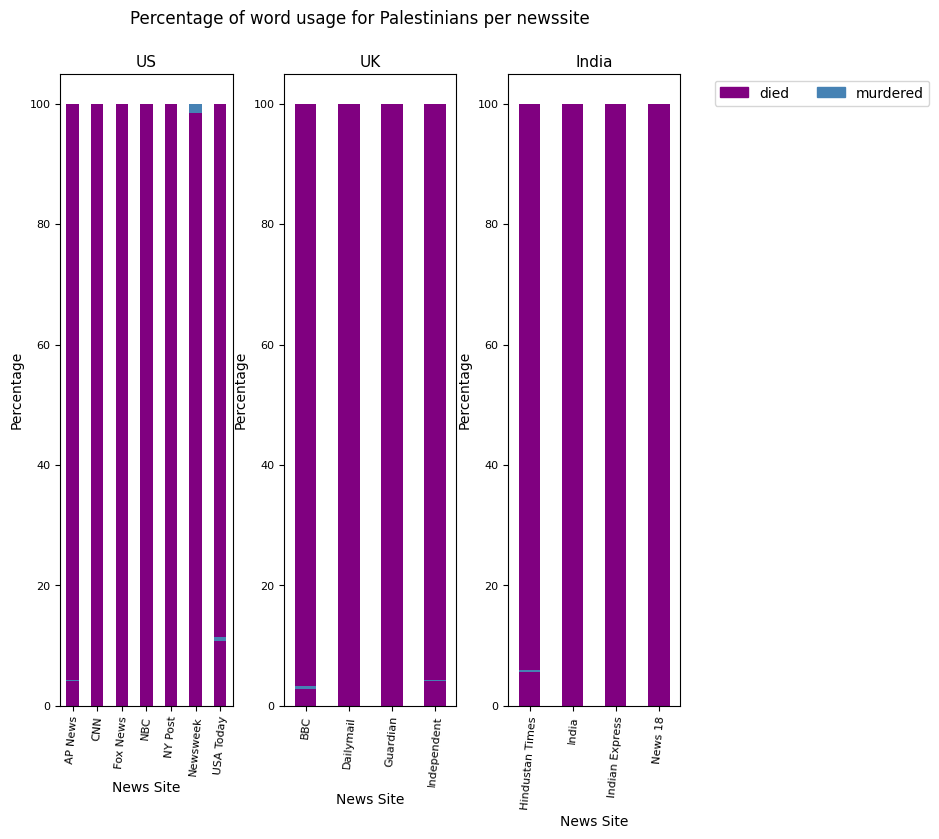

In [ ]:
## plot word usage per site per entity in one figure
padding = 5
fontsize = 11
labelsize = 8
labelrotation = 85

fig4, axs4 = plt.subplots(1, 3, figsize=(8, 8))

ax1, ax2, ax3 = axs4

pivot_us_palestinians_without_killed.plot(kind='bar', stacked=True, color=colours_3, ax=ax1, legend=False)
ax1.set_title("US", pad=padding,  fontsize= fontsize)
ax1.tick_params(axis='both', which='major', labelsize=labelsize)
ax1.tick_params(axis='x', which='major', labelrotation=labelrotation)
ax1.set_ylabel('Percentage')

pivot_uk_palestinians_without_killed.plot(kind='bar', stacked=True, color=colours_3, ax=ax2, legend=False)
ax2.set_title("UK", pad=padding,  fontsize= fontsize)
ax2.tick_params(axis='both', which='major', labelsize=labelsize)
ax2.tick_params(axis='x', which='major', labelrotation=labelrotation)
ax2.set_ylabel('Percentage')


pivot_india_palestinians_without_killed.plot(kind='bar', stacked=True, color=colours_3, ax=ax3, legend=False)
ax3.set_title("India", pad=padding,  fontsize= fontsize)
ax3.tick_params(axis='both', which='major', labelsize=labelsize)
ax3.tick_params(axis='x', which='major', labelrotation=labelrotation)
ax3.set_ylabel('Percentage')


died_patch = mpatches.Patch(color=colours_3[0], label='died')
murdered_patch = mpatches.Patch(color=colours_3[1], label='murdered')

fig4.legend(handles=[died_patch, murdered_patch],
           loc='upper right',
           bbox_to_anchor=(1.22, 0.9),
           ncol=2)

fig4.subplots_adjust(
    top=0.9,
    hspace=0.7,
    wspace=0.3
)

fig4.suptitle("Percentage of word usage for Palestinians per newssite")

plt.show()

In [ ]:
df_per_site_israelis_us = df_per_site_totals[(df_per_site_totals['Entity'] == 'Israelis') & (df_per_site_totals['Region'] == 'US')]
df_per_site_palestinians_us = df_per_site_totals[(df_per_site_totals['Entity'] == 'Palestinians') & (df_per_site_totals['Region'] == 'US')]
pivot_us_israelis = df_per_site_israelis_us.pivot(index='News Site', columns='Word', values='Percentage')
pivot_us_palestinians = df_per_site_palestinians_us.pivot(index='News Site', columns='Word', values='Percentage')


df_per_site_israelis_uk = df_per_site_totals[(df_per_site_totals['Entity'] == 'Israelis') & (df_per_site_totals['Region'] == 'UK')]
df_per_site_palestinians_uk = df_per_site_totals[(df_per_site_totals['Entity'] == 'Palestinians') & (df_per_site_totals['Region'] == 'UK')]
pivot_uk_israelis = df_per_site_israelis_uk.pivot(index='News Site', columns='Word', values='Percentage')
pivot_uk_palestinians = df_per_site_palestinians_uk.pivot(index='News Site', columns='Word', values='Percentage')


df_per_site_israelis_india = df_per_site_totals[(df_per_site_totals['Entity'] == 'Israelis') & (df_per_site_totals['Region'] == 'India')]
df_per_site_palestinians_india = df_per_site_totals[(df_per_site_totals['Entity'] == 'Palestinians') & (df_per_site_totals['Region'] == 'India')]
pivot_india_israelis = df_per_site_israelis_india.pivot(index='News Site', columns='Word', values='Percentage')
pivot_india_palestinians = df_per_site_palestinians_india.pivot(index='News Site', columns='Word', values='Percentage')

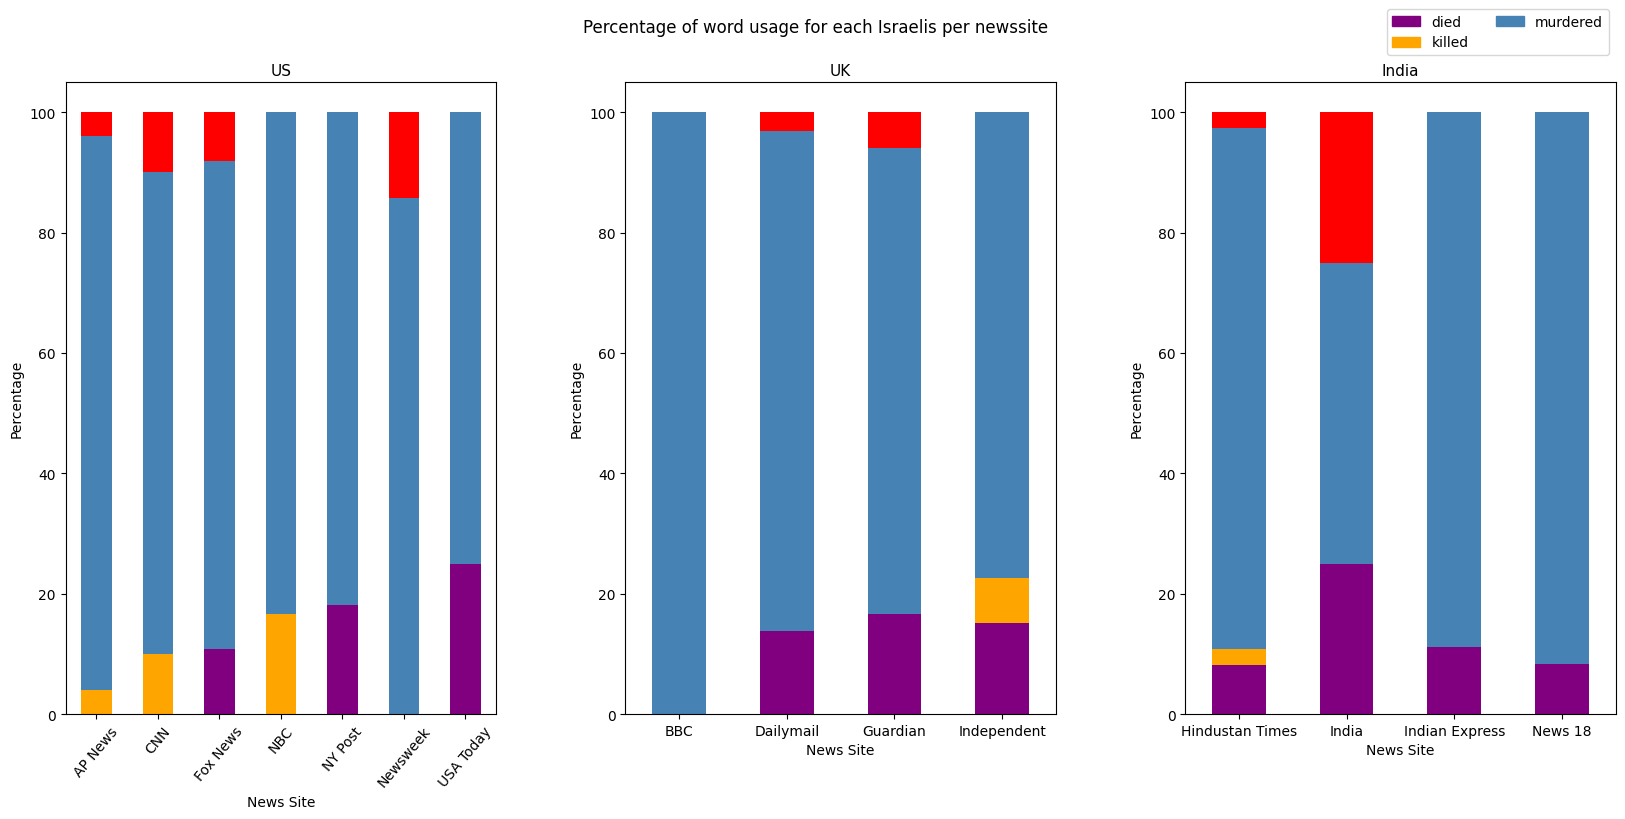

In [ ]:
padding = 5
fontsize = 11
labelsize = 10
labelrotation = 360

fig5, axs5 = plt.subplots(1, 3, figsize=(20, 8))

ax1, ax2, ax3 = axs5

pivot_us_israelis.plot(kind='bar', stacked=True, color=colours_2, ax=ax1, legend=False)
ax1.set_title("US", pad=padding,  fontsize= fontsize)
ax1.tick_params(axis='both', which='major', labelsize=labelsize)
ax1.tick_params(axis='x', which='major', labelrotation=50)
ax1.set_ylabel('Percentage')

pivot_uk_israelis.plot(kind='bar', stacked=True, color=colours_2, ax=ax2, legend=False)
ax2.set_title("UK", pad=padding,  fontsize= fontsize)
ax2.tick_params(axis='both', which='major', labelsize=labelsize)
ax2.tick_params(axis='x', which='major', labelrotation=labelrotation)
ax2.set_ylabel('Percentage')


pivot_india_israelis.plot(kind='bar', stacked=True, color=colours_2, ax=ax3, legend=False)
ax3.set_title("India", pad=padding,  fontsize= fontsize)
ax3.tick_params(axis='both', which='major', labelsize=labelsize)
ax3.tick_params(axis='x', which='major', labelrotation=labelrotation)
ax3.set_ylabel('Percentage')


died_patch = mpatches.Patch(color=colours_2[0], label='died')
killed_patch = mpatches.Patch(color=colours_2[1], label='killed')
murdered_patch = mpatches.Patch(color=colours_2[2], label='murdered')

fig5.legend(handles=[died_patch, killed_patch, murdered_patch],
           loc='upper right',
           bbox_to_anchor=(0.9, 1),
           ncol=2)

fig5.subplots_adjust(
    top=0.9,
    hspace=0.7,
    wspace=0.3
)

fig5.suptitle("Percentage of word usage for each Israelis per newssite")

fig5.savefig("wordusageisraelregion.png", bbox_inches="tight")

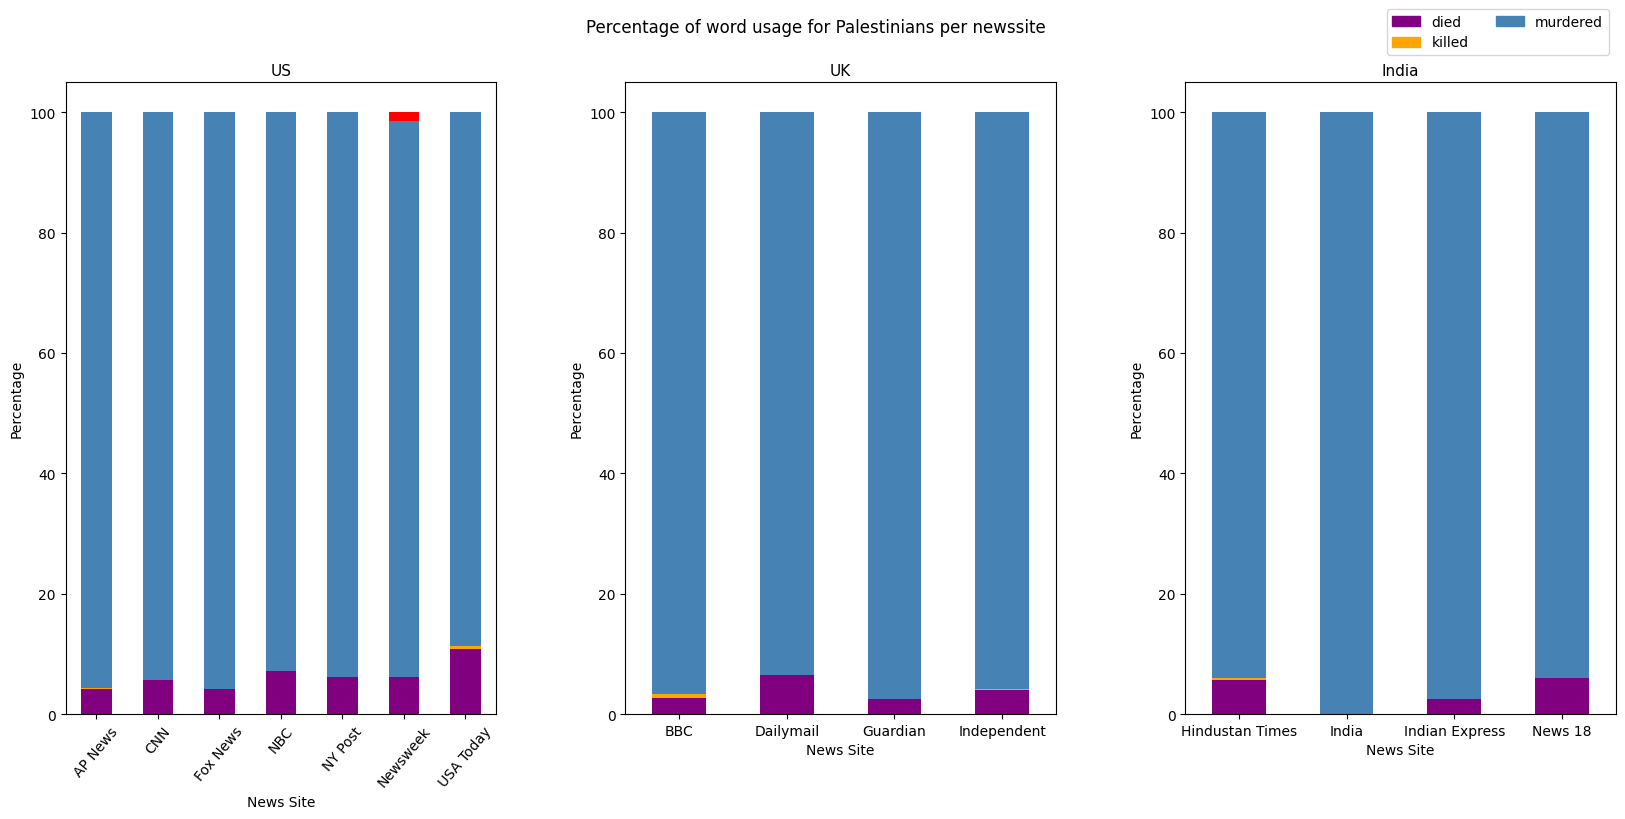

In [ ]:
padding = 5
fontsize = 11
labelsize = 10
labelrotation = 360

fig6, axs6 = plt.subplots(1, 3, figsize=(20, 8))

ax1, ax2, ax3 = axs6

pivot_us_palestinians.plot(kind='bar', stacked=True, color=colours_2, ax=ax1, legend=False)
ax1.set_title("US", pad=padding,  fontsize= fontsize)
ax1.tick_params(axis='both', which='major', labelsize=labelsize)
ax1.tick_params(axis='x', which='major', labelrotation=50)
ax1.set_ylabel('Percentage')

pivot_uk_palestinians.plot(kind='bar', stacked=True, color=colours_2, ax=ax2, legend=False)
ax2.set_title("UK", pad=padding,  fontsize= fontsize)
ax2.tick_params(axis='both', which='major', labelsize=labelsize)
ax2.tick_params(axis='x', which='major', labelrotation=labelrotation)
ax2.set_ylabel('Percentage')


pivot_india_palestinians.plot(kind='bar', stacked=True, color=colours_2, ax=ax3, legend=False)
ax3.set_title("India", pad=padding,  fontsize= fontsize)
ax3.tick_params(axis='both', which='major', labelsize=labelsize)
ax3.tick_params(axis='x', which='major', labelrotation=labelrotation)
ax3.set_ylabel('Percentage')


died_patch = mpatches.Patch(color=colours_2[0], label='died')
killed_patch = mpatches.Patch(color=colours_2[1], label='killed')
murdered_patch = mpatches.Patch(color=colours_2[2], label='murdered')

fig6.legend(handles=[died_patch, killed_patch, murdered_patch],
           loc='upper right',
           bbox_to_anchor=(0.9, 1),
           ncol=2)

fig6.subplots_adjust(
    top=0.9,
    hspace=0.7,
    wspace=0.3
)

fig6.suptitle("Percentage of word usage for Palestinians per newssite")


fig6.savefig("wordusagepalestineregion.png", bbox_inches="tight")
plt.show()

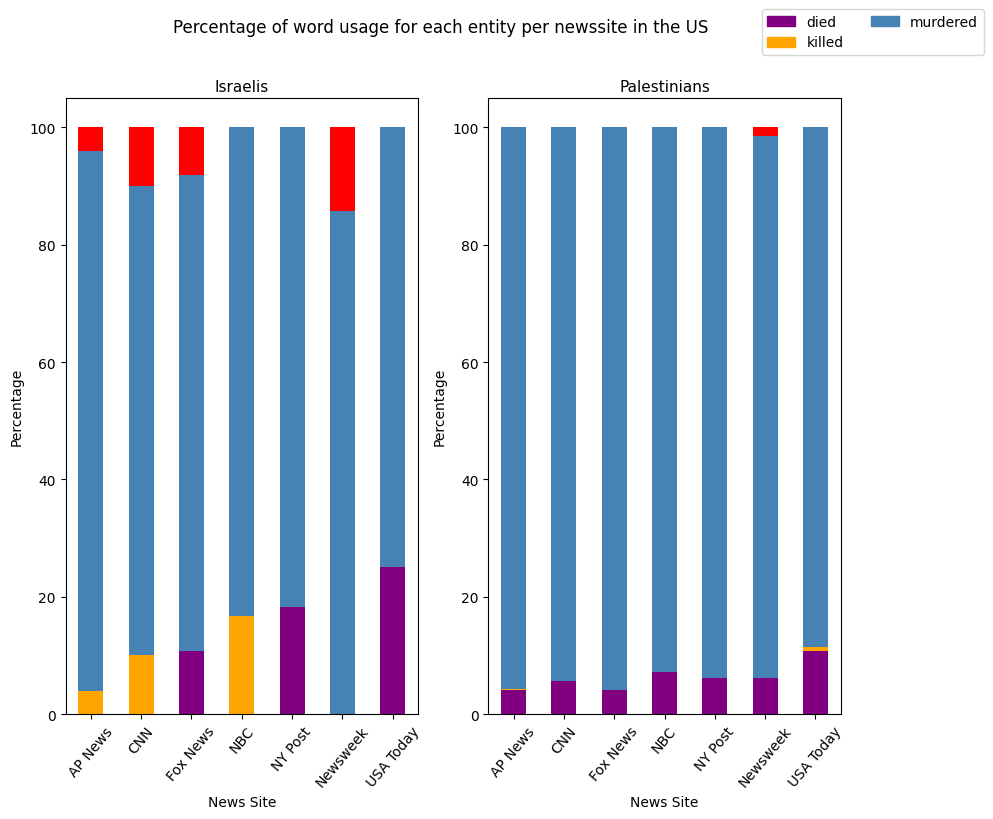

In [ ]:
fig7, axs7 = plt.subplots(1, 2, figsize=(10, 8))

ax1, ax2 = axs7

pivot_us_israelis.plot(kind='bar', stacked=True, color=colours_2, ax=ax1, legend=False)
ax1.set_title("Israelis", pad=padding,  fontsize= fontsize)
ax1.tick_params(axis='both', which='major', labelsize=labelsize)
ax1.tick_params(axis='x', which='major', labelrotation=50)
ax1.set_ylabel('Percentage')

pivot_us_palestinians.plot(kind='bar', stacked=True, color=colours_2, ax=ax2, legend=False)
ax2.set_title("Palestinians", pad=padding,  fontsize= fontsize)
ax2.tick_params(axis='both', which='major', labelsize=labelsize)
ax2.tick_params(axis='x', which='major', labelrotation=50)
ax2.set_ylabel('Percentage')

fig7.suptitle("Percentage of word usage for each entity per newssite in the US")

died_patch = mpatches.Patch(color=colours_2[0], label='died')
killed_patch = mpatches.Patch(color=colours_2[1], label='killed')
murdered_patch = mpatches.Patch(color=colours_2[2], label='murdered')

fig7.legend(handles=[died_patch, killed_patch, murdered_patch],
           loc='upper right',
           bbox_to_anchor=(1.05, 1),
           ncol=2)



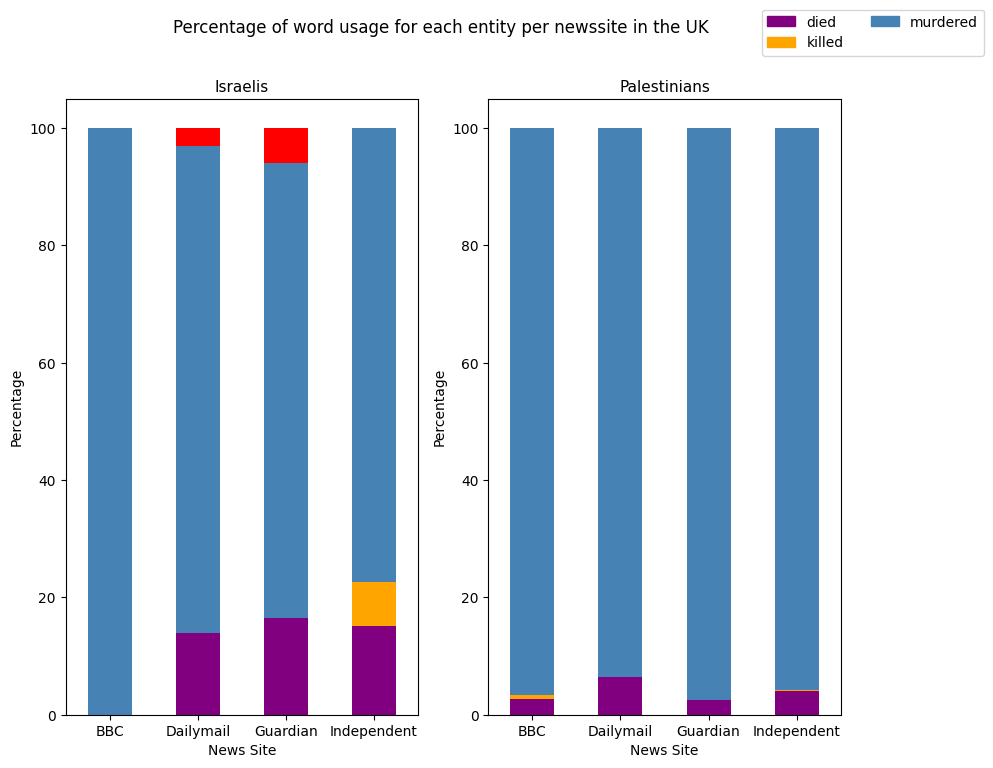

In [ ]:
fig7, axs7 = plt.subplots(1, 2, figsize=(10, 8))

ax1, ax2 = axs7

pivot_uk_israelis.plot(kind='bar', stacked=True, color=colours_2, ax=ax1, legend=False)
ax1.set_title("Israelis", pad=padding,  fontsize= fontsize)
ax1.tick_params(axis='both', which='major', labelsize=labelsize)
ax1.tick_params(axis='x', which='major', labelrotation=360)
ax1.set_ylabel('Percentage')

pivot_uk_palestinians.plot(kind='bar', stacked=True, color=colours_2, ax=ax2, legend=False)
ax2.set_title("Palestinians", pad=padding,  fontsize= fontsize)
ax2.tick_params(axis='both', which='major', labelsize=labelsize)
ax2.tick_params(axis='x', which='major', labelrotation=360)
ax2.set_ylabel('Percentage')

fig7.suptitle("Percentage of word usage for each entity per newssite in the UK")

died_patch = mpatches.Patch(color=colours_2[0], label='died')
killed_patch = mpatches.Patch(color=colours_2[1], label='killed')
murdered_patch = mpatches.Patch(color=colours_2[2], label='murdered')

fig7.legend(handles=[died_patch, killed_patch, murdered_patch],
           loc='upper right',
           bbox_to_anchor=(1.05, 1),
           ncol=2)


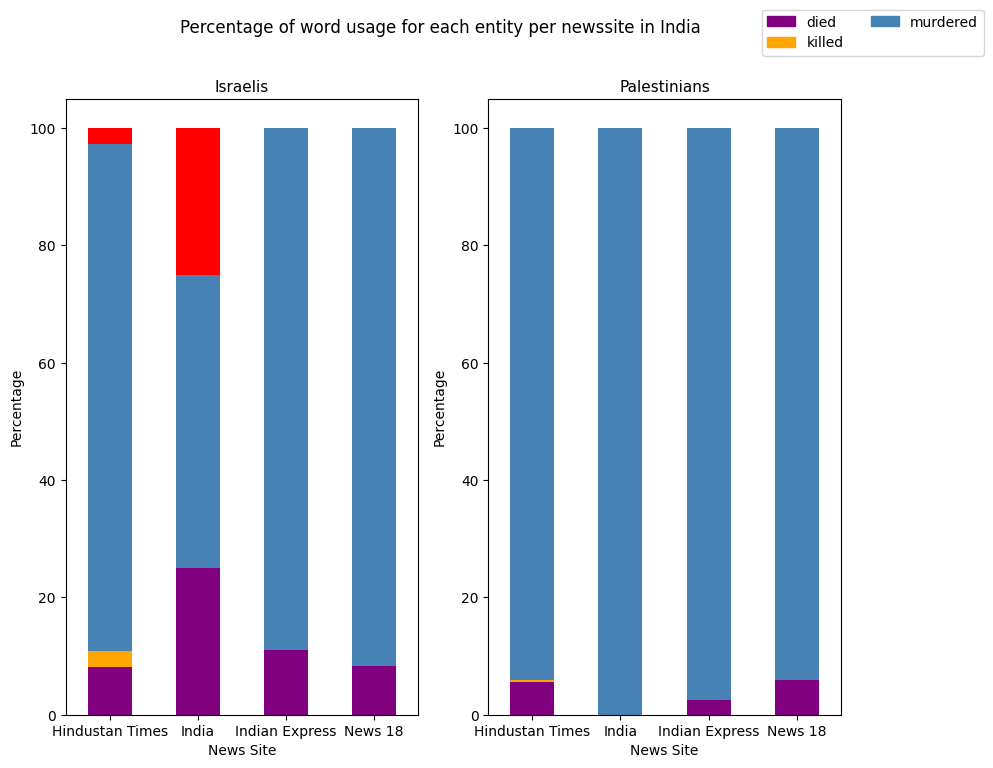

In [ ]:
fig7, axs7 = plt.subplots(1, 2, figsize=(10, 8))

ax1, ax2 = axs7

pivot_india_israelis.plot(kind='bar', stacked=True, color=colours_2, ax=ax1, legend=False)
ax1.set_title("Israelis", pad=padding,  fontsize= fontsize)
ax1.tick_params(axis='both', which='major', labelsize=labelsize)
ax1.tick_params(axis='x', which='major', labelrotation=360)
ax1.set_ylabel('Percentage')

pivot_india_palestinians.plot(kind='bar', stacked=True, color=colours_2, ax=ax2, legend=False)
ax2.set_title("Palestinians", pad=padding,  fontsize= fontsize)
ax2.tick_params(axis='both', which='major', labelsize=labelsize)
ax2.tick_params(axis='x', which='major', labelrotation=360)
ax2.set_ylabel('Percentage')

fig7.suptitle("Percentage of word usage for each entity per newssite in India")

died_patch = mpatches.Patch(color=colours_2[0], label='died')
killed_patch = mpatches.Patch(color=colours_2[1], label='killed')
murdered_patch = mpatches.Patch(color=colours_2[2], label='murdered')

fig7.legend(handles=[died_patch, killed_patch, murdered_patch],
           loc='upper right',
           bbox_to_anchor=(1.05, 1),
           ncol=2)


In [ ]:
# word = 'killed'
person = 'israel'
voice_type = 'passive'

In [ ]:
newsweek_df = analyzer.data['foxnews']

In [ ]:
# df = newsweek_df[(newsweek_df['span'].str.contains(person, case=False)) & (newsweek_df['voice_type'] == voice_type)]
df = newsweek_df[(newsweek_df['sentence'].str.contains('israel', case=False)) & (newsweek_df['sentence'].str.contains('said', case=False))]

df

,sentence,span,voice_type
15,"Iran's judiciary deputy chief, Sadeq Rahimi, s...",which is managed,passive
19,Israeli officials are leaving no options off...,preparations were being made,passive
20,Israeli officials are leaving no options off...,attack be launched,passive
30,"Speaking in the Knesset in July, Yulia Malinov...",agency was outlawed,passive
43,U.S. Secretary of State Antony Blinken said ...,deal is reached,passive
...,...,...,...
56964,Israel releases image of eliminated Hamas figu...,figures enjoying,active
56965,Israel releases image of eliminated Hamas figu...,IDF says,active
56966,Israel releases image of eliminated Hamas figu...,Forces said,active
56967,Israel releases image of eliminated Hamas figu...,Israel reportedly considering,active


In [ ]:
df.loc[4131]['sentence']

'Israel has long claimed that Hamas uses hospitals, schools, mosques and residential neighborhoods as human shields.'

In [ ]:
for index, row in df.iterrows():
  if len(row['sentence'].split(' ')) <= 25:
    print(f"{index}: {len(row['sentence'].split(' '))}")

AttributeError: 'str' object has no attribute 'iterrows'

In [ ]:
for newssite, df in analyzer.data.items():
  df_matches = df[(df['span'].str.contains(person, case=False)) & df['span'].str.contains(word, case=False)]

NameError: name 'word' is not defined